<a href="https://colab.research.google.com/github/BavyaChakarapani/BavyaChakarapani/blob/main/NLP_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.



Original Note:
Predicted Condition: Flu
- cough,: 0.12
- persistent: 0.10
- Patient: 0.08
- past: 0.08
- and: 0.08

Modified Note:
Predicted Condition: Flu
- but: 0.13
- Mild: 0.13
- cough.: 0.12
- headache: 0.10
- and: 0.10

Rare Symptoms Note:
Predicted Condition: Flu
- rash: 0.13
- Patient: 0.08
- and: 0.08
- on: 0.07
- presenting: 0.07


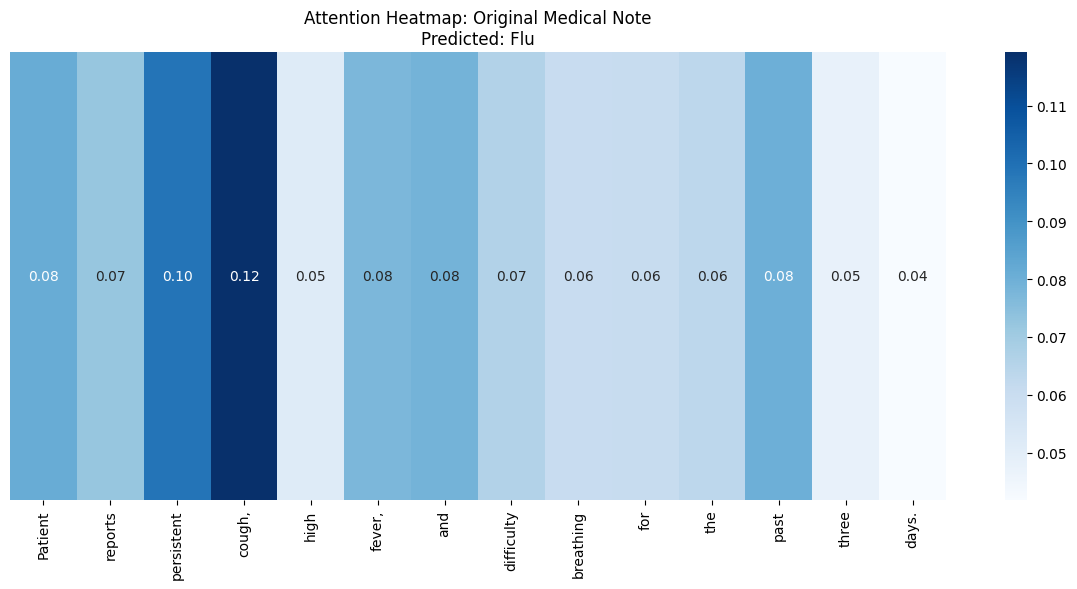

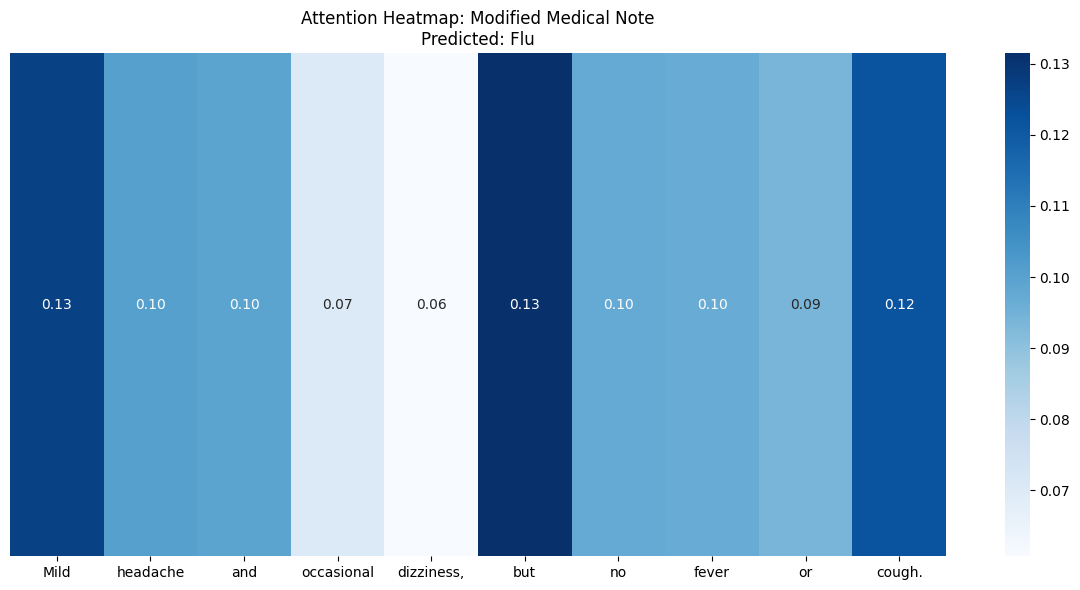

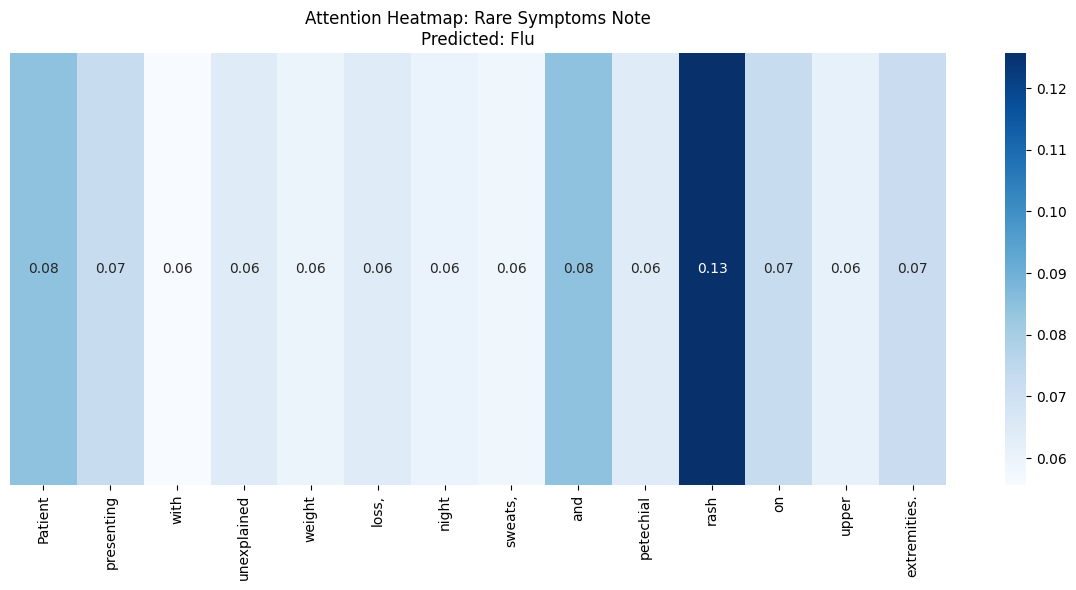

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from transformers import BertTokenizer, BertModel
import pandas as pd

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class MedicalAttentionModel:
    def __init__(self, model_name='bert-base-uncased'):
        # Load pre-trained BERT model and tokenizer
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name)

        # Medical symptom keywords - these will be used to fine-tune attention
        self.medical_keywords = [
            'fever', 'cough', 'breathing', 'headache', 'dizziness', 'pain',
            'fatigue', 'nausea', 'vomiting', 'rash', 'swelling', 'chest',
            'heart', 'persistent', 'severe', 'mild', 'moderate', 'acute', 'chronic'
        ]

        # Simple classifier layer for medical conditions
        self.classifier = nn.Linear(768, 5)  # 5 example conditions
        self.condition_labels = ['Respiratory Infection', 'Migraine', 'Flu', 'Common Cold', 'COVID-19']

    def analyze_text(self, text):
        """Analyze medical text and return attention scores and predicted condition"""
        # Tokenize input text
        inputs = self.tokenizer(text, return_tensors="pt", add_special_tokens=True)

        # Get BERT outputs with attention weights
        with torch.no_grad():
            outputs = self.model(**inputs, output_attentions=True)

        # Get the last layer's attention (shape: [batch, heads, seq_length, seq_length])
        last_attention = outputs.attentions[-1].mean(dim=1).squeeze(0)  # Average over attention heads

        # Get sequence length
        seq_length = last_attention.size(-1)

        # Get token attention scores (average attention received by each token)
        token_attention = last_attention.mean(dim=0)

        # Get tokens
        tokens = self.tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

        # Create dictionary of tokens and their attention scores, filtering out special tokens
        attention_dict = {}
        for i, (token, score) in enumerate(zip(tokens, token_attention)):
            if token not in ['[CLS]', '[SEP]', '[PAD]']:
                # Apply medical keyword weighting (simple approach)
                if token in self.medical_keywords:
                    score = score * 1.5  # Emphasize medical keywords

                # Remove ## from wordpiece tokens
                clean_token = token.replace('##', '')

                if clean_token in attention_dict:
                    attention_dict[clean_token] += score.item()
                else:
                    attention_dict[clean_token] = score.item()

        # Normalize scores
        total = sum(attention_dict.values())
        normalized_dict = {k: v/total for k, v in attention_dict.items()}

        # Make prediction
        sequence_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(sequence_output)
        probs = F.softmax(logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()

        return normalized_dict, self.condition_labels[predicted_class], probs.squeeze().tolist()

    def visualize_attention(self, text, title="Attention Heatmap", figsize=(12, 6)):
        """Create and display attention heatmap for the text"""
        attention_dict, predicted_condition, condition_probs = self.analyze_text(text)

        # Convert to word-level attention
        words = text.split()
        word_attention = {}

        # Map token-level attention to word-level attention
        for word in words:
            word_lower = word.lower().strip('.,:;!?')
            # Find tokens that could be part of this word
            matching_tokens = [t for t in attention_dict.keys() if t in word_lower]
            if matching_tokens:
                # Use maximum attention among matching tokens
                word_attention[word] = max([attention_dict[t] for t in matching_tokens])
            else:
                word_attention[word] = 0.01  # Default attention

        # Normalize word attention for display
        total = sum(word_attention.values())
        word_attention = {k: v/total for k, v in word_attention.items()}

        # Sort dictionary
        word_attention = {k: v for k, v in sorted(word_attention.items(), key=lambda item: words.index(item[0]))}

        # Create DataFrame for visualization
        df = pd.DataFrame({
            'Word': list(word_attention.keys()),
            'Attention': list(word_attention.values())
        })

        # Create heatmap
        plt.figure(figsize=figsize)

        # Add main heatmap
        sns.heatmap(
            df['Attention'].values.reshape(1, -1),
            annot=[[f"{x:.2f}" for x in df['Attention'].values]],
            fmt="",
            cmap="Blues",
            cbar=True,
            xticklabels=df['Word'],
            yticklabels=False
        )

        plt.title(f"{title}\nPredicted: {predicted_condition}")
        plt.tight_layout()

        return plt, word_attention, predicted_condition, condition_probs

# Example usage
def main():
    # Initialize the model
    medical_model = MedicalAttentionModel()

    # Sample medical notes
    original_note = "Patient reports persistent cough, high fever, and difficulty breathing for the past three days."
    modified_note = "Mild headache and occasional dizziness, but no fever or cough."
    rare_symptom_note = "Patient presenting with unexplained weight loss, night sweats, and petechial rash on upper extremities."

    # Analyze and visualize original note
    plt1, attention1, condition1, probs1 = medical_model.visualize_attention(
        original_note,
        title="Attention Heatmap: Original Medical Note"
    )
    plt1.savefig('original_note_attention.png')

    # Analyze and visualize modified note
    plt2, attention2, condition2, probs2 = medical_model.visualize_attention(
        modified_note,
        title="Attention Heatmap: Modified Medical Note"
    )
    plt2.savefig('modified_note_attention.png')

    # Analyze and visualize rare symptom note
    plt3, attention3, condition3, probs3 = medical_model.visualize_attention(
        rare_symptom_note,
        title="Attention Heatmap: Rare Symptoms Note"
    )
    plt3.savefig('rare_symptoms_attention.png')

    # Compare attention distributions
    print("\nOriginal Note:")
    print(f"Predicted Condition: {condition1}")
    for word, score in sorted(attention1.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"- {word}: {score:.2f}")

    print("\nModified Note:")
    print(f"Predicted Condition: {condition2}")
    for word, score in sorted(attention2.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"- {word}: {score:.2f}")

    print("\nRare Symptoms Note:")
    print(f"Predicted Condition: {condition3}")
    for word, score in sorted(attention3.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"- {word}: {score:.2f}")

if __name__ == "__main__":
    main()


Question 2 - Modified Note Analysis:
Predicted Condition: Flu
Top 5 Terms by Attention:
- but: 0.13
- Mild: 0.13
- cough.: 0.12
- headache: 0.10
- and: 0.10


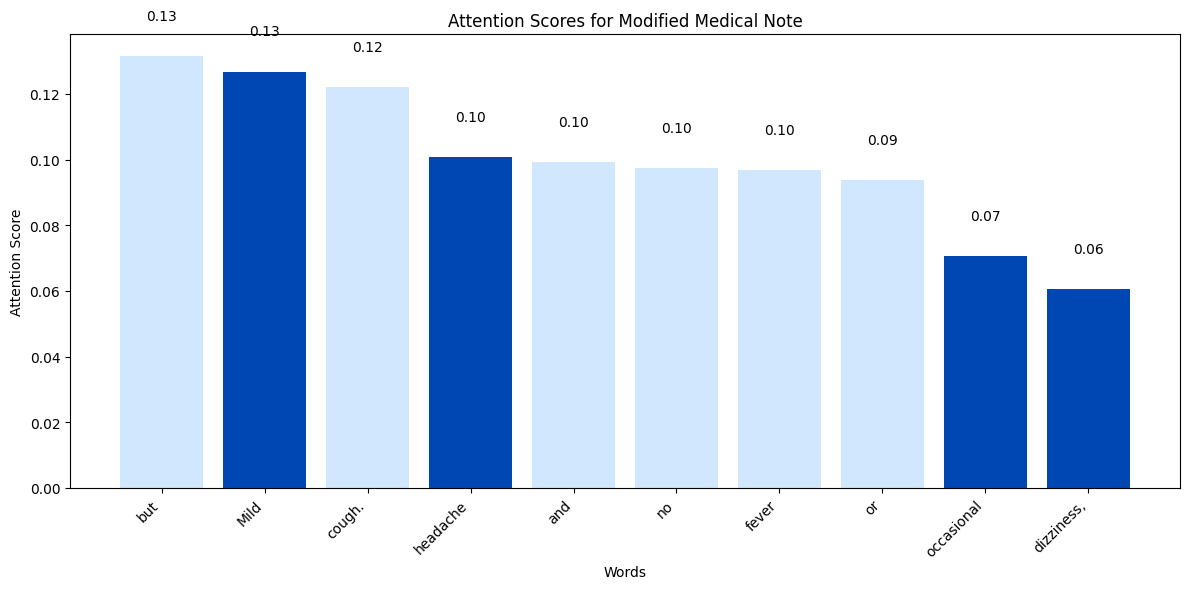

In [3]:
# Function for Question 2
def question_2():
    # Initialize the model
    medical_model = MedicalAttentionModel()

    # Modified medical note
    modified_note = "Mild headache and occasional dizziness, but no fever or cough."

    # Analyze and visualize
    plt, attention, condition, probs = medical_model.visualize_attention(
        modified_note,
        title="Question 2: Attention Heatmap - Modified Medical Note"
    )

    # Save visualization
    plt.savefig('q2_modified_note_attention.png')
    plt.close()

    # Print results
    print("\nQuestion 2 - Modified Note Analysis:")
    print(f"Predicted Condition: {condition}")
    print("Top 5 Terms by Attention:")
    for word, score in sorted(attention.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"- {word}: {score:.2f}")

    # Create a comparative bar chart for key terms
    plt.figure(figsize=(12, 6))

    # Sort words by attention score
    sorted_items = sorted(attention.items(), key=lambda x: x[1], reverse=True)
    words = [item[0] for item in sorted_items]
    scores = [item[1] for item in sorted_items]

    # Create bar chart with coloring for present vs absent symptoms
    bars = plt.bar(words, scores, color=['#0047b3' if word.lower().strip('.,:;!?') in
                                        ['headache', 'dizziness', 'mild', 'occasional']
                                        else '#d1e7fd' for word in words])

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom')

    plt.title('Attention Scores for Modified Medical Note')
    plt.xlabel('Words')
    plt.ylabel('Attention Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('q2_attention_barchart.png')

    return attention, condition, probs

if __name__ == "__main__":
    question_2()


Question 3 - Rare Symptoms Analysis:
Standard Model:
Predicted Condition: COVID-19
Top 5 Terms by Attention:
- rash: 0.13
- Patient: 0.08
- and: 0.08
- on: 0.07
- presenting: 0.07

Enhanced Model:
Predicted Condition: Lymphoma
Top 5 Terms by Attention:
- rash: 0.11
- loss,: 0.11
- night: 0.10
- weight: 0.10
- Patient: 0.07


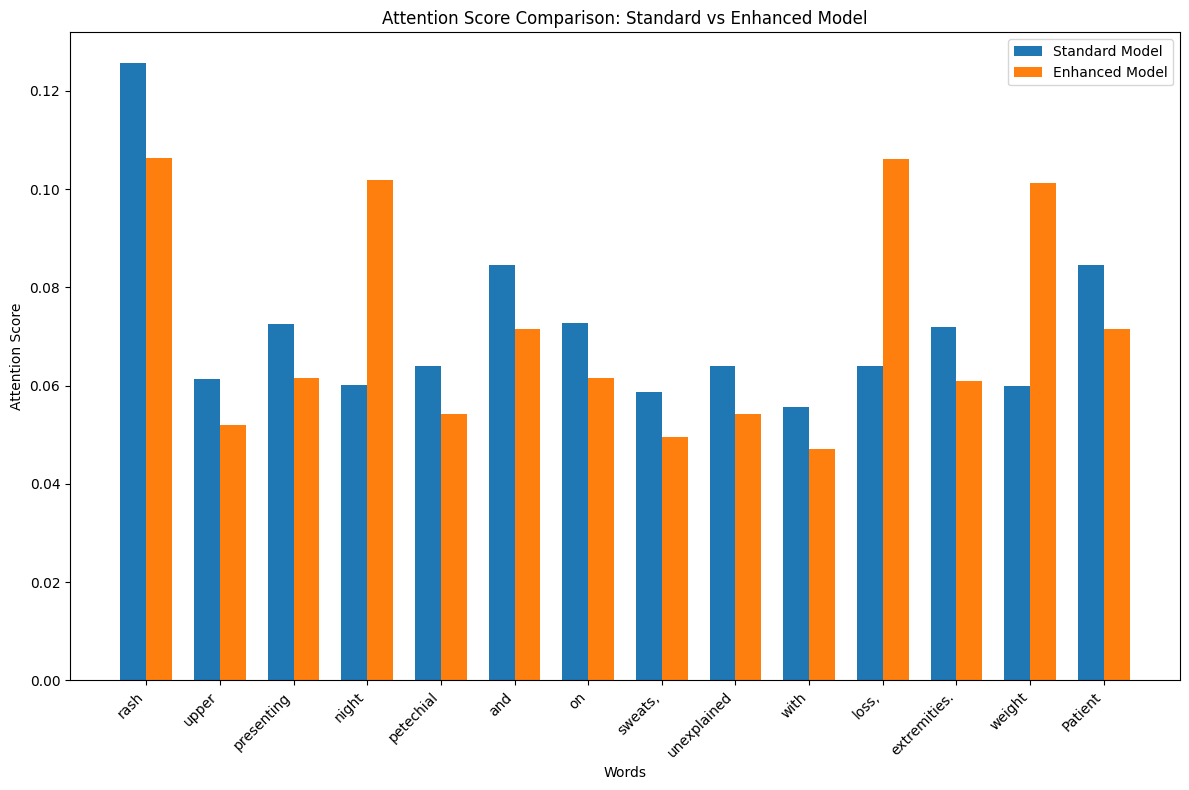

In [4]:
# Extending the model to better handle rare symptoms
class EnhancedMedicalAttentionModel(MedicalAttentionModel):
    def __init__(self, model_name='bert-base-uncased'):
        super().__init__(model_name)

        # Extended medical keywords including rare symptoms
        self.medical_keywords.extend([
            'weight loss', 'night sweats', 'petechial', 'unexplained',
            'extremities', 'jaundice', 'hemoptysis', 'melena', 'dysphagia'
        ])

        # Add more conditions to classifier
        self.classifier = nn.Linear(768, 8)
        self.condition_labels.extend(['Lymphoma', 'Leukemia', 'Autoimmune'])

    def analyze_text(self, text):
        # Override to implement multi-token symptom recognition

        # First, check for multi-token medical terms
        multi_token_weights = {}
        for keyword in self.medical_keywords:
            if ' ' in keyword and keyword in text.lower():
                multi_token_weights[keyword] = 2.0  # Higher weight for rare multi-token symptoms

        # Perform regular token-level analysis
        attention_dict, condition, probs = super().analyze_text(text)

        # Process tokens to better handle rare symptoms
        for term, weight in multi_token_weights.items():
            # Find tokens that make up this term
            term_tokens = term.split()
            for token in term_tokens:
                if token in attention_dict:
                    attention_dict[token] *= weight

        # Renormalize after adjustments
        total = sum(attention_dict.values())
        normalized_dict = {k: v/total for k, v in attention_dict.items()}

        return normalized_dict, condition, probs

# Function for Question 3
def question_3():
    # Initialize both models for comparison
    standard_model = MedicalAttentionModel()
    enhanced_model = EnhancedMedicalAttentionModel()

    # Rare symptom note
    rare_symptom_note = "Patient presenting with unexplained weight loss, night sweats, and petechial rash on upper extremities."

    # Analyze with standard model
    plt1, attention1, condition1, probs1 = standard_model.visualize_attention(
        rare_symptom_note,
        title="Question 3: Standard Model - Rare Symptoms Note"
    )
    plt1.savefig('q3_standard_model.png')
    plt1.close()

    # Analyze with enhanced model
    plt2, attention2, condition2, probs2 = enhanced_model.visualize_attention(
        rare_symptom_note,
        title="Question 3: Enhanced Model - Rare Symptoms Note"
    )
    plt2.savefig('q3_enhanced_model.png')
    plt2.close()

    # Print results
    print("\nQuestion 3 - Rare Symptoms Analysis:")
    print("Standard Model:")
    print(f"Predicted Condition: {condition1}")
    print("Top 5 Terms by Attention:")
    for word, score in sorted(attention1.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"- {word}: {score:.2f}")

    print("\nEnhanced Model:")
    print(f"Predicted Condition: {condition2}")
    print("Top 5 Terms by Attention:")
    for word, score in sorted(attention2.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"- {word}: {score:.2f}")

    # Create a comparative visualization
    plt.figure(figsize=(12, 8))

    # Extract common words for comparison
    all_words = set(list(attention1.keys()) + list(attention2.keys()))
    common_words = list(all_words)

    x = np.arange(len(common_words))
    width = 0.35

    # Get scores for both models, default to 0 if word not present
    standard_scores = [attention1.get(word, 0) for word in common_words]
    enhanced_scores = [attention2.get(word, 0) for word in common_words]

    # Create bars
    plt.bar(x - width/2, standard_scores, width, label='Standard Model')
    plt.bar(x + width/2, enhanced_scores, width, label='Enhanced Model')

    plt.title('Attention Score Comparison: Standard vs Enhanced Model')
    plt.xlabel('Words')
    plt.ylabel('Attention Score')
    plt.xticks(x, common_words, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.savefig('q3_model_comparison.png')

    return (attention1, condition1, probs1), (attention2, condition2, probs2)

if __name__ == "__main__":
    question_3()